# Overview

This notebook provides a step-by-step example of our processing pipeline for a single candidate location in Ethiopia, from acquiring imagery to creating the final market activity plot.

Note that we are unable to provide the original Planet imagery, but we are able to provide all intermediate products and analyses subsequent to the initial imagery processing. 

# Step 0: Setup Instructions

This notebook requires both Python and Node.js dependencies to run properly. Follow these steps to set up your environment:

## Python Environment Setup

#### 1. Create and activate a virtual environment (recommended):
```bash
# Create virtual environment
python3 -m venv .venv

# Activate virtual environment
# On macOS/Linux:
source .venv/bin/activate
# On Windows:
# .venv\Scripts\activate
```

#### 2. Install Python dependencies:
```bash
pip install --upgrade pip
pip install -r requirements.txt
```

The `requirements.txt` file includes all necessary packages.

## Node and ee-runner Setup

#### 1. Install Node.js (version 18+ required, 20.x recommended):
- Visit [nodejs.org](https://nodejs.org/) and install Node.js version 20.x
- Or use a version manager like nvm:
```bash
# Using nvm (recommended)
nvm install 20
nvm use 20
```

#### 2. Install ee-runner:
```bash
# Run this command in the project root directory
npm install
```

This installs `@pdingus/ee-runner` locally, which is required for executing Google Earth Engine scripts.

**Note:** The notebook automatically detects the Node.js and ee-runner paths, so you don't need to manually configure paths.

## Earth Engine Setup

This is required for the notebook to work with Google Earth Engine scripts.

```bash
# Install Earth Engine API (should already be in requirements.txt)
pip install earthengine-api

# Authenticate with Earth Engine
earthengine authenticate

# Set your Earth Engine project (replace with your project ID)
earthengine set_project "your-project-id"
```

The gcloud CLI is required for authenticating ee-runner, which can be accessed here: [https://cloud.google.com/sdk/docs/install](https://cloud.google.com/sdk/docs/install). After installing, set project:

```bash
# Set gcloud project
gcloud config set project your-project-name
```

## Optional: Planet Labs API (for imagery download):
- Sign up for a Planet Labs account
- Obtain an API key from your Planet account dashboard

In [7]:
import subprocess
import os
import numpy as np
import rasterio
import folium
from matplotlib import cm
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

In [8]:
loc = "lon38_5671lat9_2948"
locGroup = "79_Ethiopia"
bucket = "p79ethiopia65"
country="Ethiopia"
GEEproject="p155mali8"

# Get the current working directory (project root)
import os
current_dir = os.getcwd()
# If we're in the code subdirectory, go up one level to project root
if current_dir.endswith('/code'):
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

repl_pkg_path = project_root

# Dynamically find Node.js path
try:
    nodePath = subprocess.check_output(["which", "node"], text=True).strip()
    
    # Check Node.js version
    node_version = subprocess.check_output([nodePath, "--version"], text=True).strip()
    major_version = int(node_version.split('.')[0][1:])  # Remove 'v' and get major version
    
    print(f"Found Node.js at: {nodePath}")
    print(f"Node.js version: {node_version}")
    
    if major_version < 18:
        print(f"Warning: Node.js version {node_version} is quite old. Consider upgrading to v20.x for best compatibility.")
    elif major_version >= 18:
        print("Node.js version is compatible")
        
except subprocess.CalledProcessError:
    raise RuntimeError("Node.js not found. Please install Node.js version 20.x")

# Find ee-runner in local node_modules
eerunnerPath = os.path.join(project_root, "node_modules", ".bin", "ee-runner")
if not os.path.exists(eerunnerPath):
    raise RuntimeError(f"ee-runner not found at {eerunnerPath}. Please run 'npm install' in the project root directory.")

print(f"Found ee-runner at: {eerunnerPath}")
print(f"Project root: {repl_pkg_path}")

Found Node.js at: /Users/pauldingus/.nvm/versions/node/v18.20.8/bin/node
Node.js version: v18.20.8
Node.js version is compatible
Found ee-runner at: /Users/pauldingus/Dropbox/mai_shared/Submissions/MktAct/NatureComm/ReplicationPackage/node_modules/.bin/ee-runner
Project root: /Users/pauldingus/Dropbox/mai_shared/Submissions/MktAct/NatureComm/ReplicationPackage


The GEE code in the following cell takes as inputs the outlines of the candidate location and the downloaded imagery to produce a .tif file where each band represents the intensity of apperance differences on average across the images in the sample by day-of-week, against their respective reference composites. Running this code requires access to the proprietary imagery as well as a GEE account. We therefore provide the output of the code and visualize it in a subsequent cell. 

# Step 1: Download Imagery

This notebook demonstrates the satellite imagery download functionality. The system downloads satellite imagery from Planet Labs to a Google Cloud Storage bucket for subsequent analysis.

The download system operates in three modes based on provided credentials:

1. **Structure Overview** (No credentials) - Shows the complete system architecture and API request structure
2. **Preview Mode** (API key only) - Connects to Planet API to analyze available imagery 
3. **Full Download** (API key + bucket) - Actually downloads and processes satellite imagery

This demonstration is designed to verify the system works correctly. By default, it runs in Structure Overview mode (no credentials required), but you can optionally provide credentials to test the other modes.

In [9]:
# Import required modules
import sys
import os
from data_derivation.download_imagery import downloader

# Demonstration parameters
location = "lon38_5671lat9_2948" # Unique identifier for the location of interest
location_group = "79_Ethiopia" # Organizational parameter used for structureing our data
end_date = "2024-12-31"
max_cloud_cover = 30

# Optional credentials (leave as None for structure overview mode)
planet_api_key = None  # Replace with your Planet API key to test preview mode
gcs_bucket = None      # Replace with your GCS bucket name to test download mode

In [ ]:
# Run the download demonstration
try:
    result = downloader(
        loc=location,
        locGroup=location_group,
        endDate=end_date,
        maxCloudCover=max_cloud_cover,
        planet_api_key=planet_api_key,
        gcs_bucket=gcs_bucket
    )
        
except Exception as e:
    print(f"\nException occurred: {e}")
    print("This may be expected if using invalid credentials for demonstration purposes")

# Step 2: Create Difference Image Using Google Earth Engine

In [16]:
# Define the path to the input file
file_path = f"./data_derivation/01_prep.txt"

# Read the content of the input file
with open(file_path, "r") as file:
    content = file.read()

# Replace placeholders in the file content with actual variable values
content = (content.replace("INSERT_LOC_HERE", loc)
                  .replace("INSERT_LOC_GROUP_HERE", locGroup)
                  .replace("INSERT_BUCKET_HERE", bucket)
                  .replace("INSERT_COUNTRY_HERE", country))

# Define the path for the new file with "_torun" suffix
new_file_path = file_path.replace(".txt", "_torun.txt")

# Write the updated content to the new file
with open(new_file_path, "w") as new_file:
    new_file.write(content)

# Execute the updated script using Node.js and the ee-runner tool
subprocess.call([
    nodePath,                # Path to the Node.js executable
    eerunnerPath,            # Path to the ee-runner script
    new_file_path,           # Path to the updated script file
    f"--project={GEEproject}"  # Specify the GEE project as a command-line argument
])


Running script: ./data_derivation/01_prep_torun.txt


0


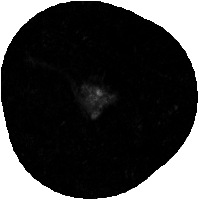
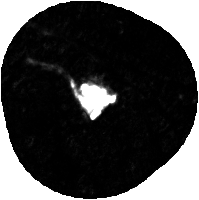

In [19]:
# Define the path to the difference image file
diffImg_path = os.path.join("..", "datasets", "intermediate_outputs", f"{loc}_diffImg.tif")

# Open the difference image using rasterio
with rasterio.open(diffImg_path) as src:
    # Extract band names and image bounds
    band_names = src.descriptions
    bounds = src.bounds

    # Calculate the center latitude and longitude for the map
    center_lat = (bounds.top + bounds.bottom) / 2
    center_lon = (bounds.left + bounds.right) / 2

    # Initialize a folium map centered at the calculated location
    m = folium.Map(location=[center_lat, center_lon], zoom_start=18, tiles='CartoDB positron')

    # Function to convert a band to RGBA format using a colormap
    def rgba_from_band_01(band, cmap_name='gray', vmin=None, vmax=None):
        arr = np.ma.filled(band, np.nan).astype(float)  # Replace masked values with NaN
        arr = np.clip((arr - vmin) / (vmax - vmin), 0.0, 1.0)  # Normalize to [0, 1]
        rgba = np.zeros((*arr.shape, 4), dtype=np.uint8)  # Initialize RGBA array
        mask = ~np.isnan(arr)  # Mask for valid data
        rgba[mask, :3] = (cm.get_cmap(cmap_name)(arr[mask])[:, :3] * 255).astype(np.uint8)  # Apply colormap
        rgba[mask, 3] = 255  # Set alpha channel for valid data
        return rgba

    # Loop through the first two bands and add them as overlays to the map
    for i in range(1, 3):
        band = src.read(i, masked=True)  # Read the band as a masked array
        rgba = rgba_from_band_01(band, 'gray', vmin=0, vmax=5)  # Convert to RGBA
        folium.raster_layers.ImageOverlay(
            image=rgba,
            bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
            name=f"Day-of-week {i-1} ({['Sunday', 'Monday'][i-1]})",  # Add a descriptive name
            opacity=1,  # Set overlay opacity
        ).add_to(m)

    # Add a satellite tile layer and a layer control to the map
    folium.TileLayer('Esri.WorldImagery', name='Satellite').add_to(m)
    folium.LayerControl().add_to(m)

# Display the map
m

After completing 01_prep, we can now extract the shapes with periodic appearance differences using 02_mktShape.txt

# Step 3: Create Market Shape Using Google Earth Engine

In [ ]:
# Define the path to the input file
file_path = f"{repl_pkg_path}/code\\data_derivation\\02_mktShape.txt"

# Read the content of the input file
with open(file_path, "r") as file:
    content = file.read()

# Replace placeholders in the file content with actual variable values
content = (content.replace("INSERT_LOC_HERE", loc)
                  .replace("INSERT_LOC_GROUP_HERE", locGroup)
                  .replace("INSERT_BUCKET_HERE", bucket)
                  .replace("INSERT_COUNTRY_HERE", country))

# Define the path for the new file with "_torun" suffix
new_file_path = file_path.replace(".txt", "_torun.txt")

# Write the updated content to the new file
with open(new_file_path, "w") as new_file:
    new_file.write(content)

# Execute the updated script using Node.js and the ee-runner tool
subprocess.call([
    nodePath,                # Path to the Node.js executable
    eerunnerPath,            # Path to the ee-runner script
    new_file_path,           # Path to the updated script file
    f"--project={GEEproject}"  # Specify the GEE project as a command-line argument
])


The following cell presents the output.

In [ ]:
# Define the path to the shapefile
shapefile_path = os.path.join(
    repl_pkg_path, 
    "datasets", 
    "intermediate_outputs", 
    f"{locGroup}_shapes_shp_MpM6_{locGroup}{loc}.shp"
)

# Load the shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)

# Filter rows where 'subStrictn' equals 100 (removes rings for visualization purposes)
gdf = gdf[gdf['subStrictn'] == 100]

# Filter the GeoDataFrame to keep:
# 1. Shapes with the smallest 'strictness' for each 'weekdayShp'
# 2. Shapes with 'strictness' values that are multiples of four
idx_min_strictness = gdf.groupby('weekdayShp')['strictness'].idxmin()
idx_multiple_of_four = gdf[gdf['strictness'] % 4 == 0].index
combined_indices = pd.Index(idx_min_strictness).union(pd.Index(idx_multiple_of_four))
gdf = gdf.loc[combined_indices]

# Assign a color to each unique value of 'strictness' based on its rank
strictness_colors = {
    value: cm.get_cmap('viridis')(rank / len(strictness_values))
    for rank, value in enumerate(sorted(strictness_values))
}

# Sort the GeoDataFrame by 'weekdayShp' (ascending) and 'strictness' (descending)
gdf = gdf.sort_values(by=['weekdayShp', 'strictness'], ascending=[True, False])

# Calculate the centroid of the shapefile's geometry to center the map
centroid = gdf.geometry.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=18, tiles='CartoDB positron')

# Add the shapes to the map with colors based on 'strictness'
for _, row in gdf.iterrows():
    color = f"#{int(strictness_colors[row['strictness']][0] * 255):02x}" \
            f"{int(strictness_colors[row['strictness']][1] * 255):02x}" \
            f"{int(strictness_colors[row['strictness']][2] * 255):02x}"
    folium.GeoJson(
        data=row['geometry'],
        name=f"Weekday {int(row['weekdayShp'])}, Strictness {row['strictness']}",
        style_function=lambda x, color=color: {'color': color, 'weight': 2, 'fillOpacity': 0.5}
    ).add_to(m)

# Add a satellite tile layer and a layer control to the map
folium.TileLayer('Esri.WorldImagery', name='Satellite').add_to(m)
folium.LayerControl().add_to(m)

# Display the map
m

If there is at least one shape in the output 02_mktShape that is associated with StrictnessRank<20 (the threshold shown in Fig. 2), or if the detected shape is manually assessed to identify a marketplace despite higher values of StrictnessRank, we execute the following step, 03_actPrep. This step generates a .tif where each band represents the appearance differences by captured image in the area covered by the detected shape. This data will subsequently be exported as a CSV for further processing. Note that at this point, we hanve't determined yet which of the detected shapes represents the actual market. 

# Step 3: Create Image Collection for Activity Analysis in Earth Engine

In [ ]:
# Define the path to the input file
file_path = f"{repl_pkg_path}/code\\data_derivation\\03_actPrep.txt"

# Read the content of the input file
with open(file_path, "r") as file:
    content = file.read()

# Replace placeholders in the file content with actual variable values
content = (content.replace("INSERT_LOC_HERE", loc)
                  .replace("INSERT_LOC_GROUP_HERE", locGroup)
                  .replace("INSERT_BUCKET_HERE", bucket)
                  .replace("INSERT_COUNTRY_HERE", country))

# Define the path for the new file with "_torun" suffix
new_file_path = file_path.replace(".txt", "_torun.txt")

# Write the updated content to the new file
with open(new_file_path, "w") as new_file:
    new_file.write(content)

# Execute the updated script using Node.js and the ee-runner tool
subprocess.call([
    nodePath,                # Path to the Node.js executable
    eerunnerPath,            # Path to the ee-runner script
    new_file_path,           # Path to the updated script file
    f"--project={GEEproject}"  # Specify the GEE project as a command-line argument
])

# Note: The resulting image is stored in datasets/intermediate_outputs/{loc}_actPrep.tif")


The final steps in GEE converts the output from 03_actPrep into a CSV and export a second CSV with the properties of each of the images, such as cloud cover or acquisition time.

# Step 4: Create Activity Output in Earth Engine

In [ ]:
# Define the path to the input file
file_path = f"{repl_pkg_path}/code\\data_derivation\\04_activity.txt"

# Read the content of the input file
with open(file_path, "r") as file:
    content = file.read()

# Replace placeholders in the file content with actual variable values
content = (content.replace("INSERT_LOC_HERE", loc)
                  .replace("INSERT_LOC_GROUP_HERE", locGroup)
                  .replace("INSERT_BUCKET_HERE", bucket)
                  .replace("INSERT_COUNTRY_HERE", country))

# Define the path for the new file with "_torun" suffix
new_file_path = file_path.replace(".txt", "_torun.txt")

# Write the updated content to the new file
with open(new_file_path, "w") as new_file:
    new_file.write(content)

# Execute the updated script using Node.js and the ee-runner tool
subprocess.call([
    nodePath,                # Path to the Node.js executable
    eerunnerPath,            # Path to the ee-runner script
    new_file_path,           # Path to the updated script file
    f"--project={GEEproject}"  # Specify the GEE project as a command-line argument
])

# Define the path to the input file
file_path = f"{repl_pkg_path}/code\\data_derivation\\04a_properties.txt"

# Read the content of the input file
with open(file_path, "r") as file:
    content = file.read()

# Replace placeholders in the file content with actual variable values
content = (content.replace("INSERT_LOC_HERE", loc)
                  .replace("INSERT_LOC_GROUP_HERE", locGroup)
                  .replace("INSERT_BUCKET_HERE", bucket)

# Define the path for the new file with "_torun" suffix
new_file_path = file_path.replace(".txt", "_torun.txt")

# Write the updated content to the new file
with open(new_file_path, "w") as new_file:
    new_file.write(content)

# Execute the updated script using Node.js and the ee-runner tool
subprocess.call([
    nodePath,                # Path to the Node.js executable
    eerunnerPath,            # Path to the ee-runner script
    new_file_path,           # Path to the updated script file
    f"--project={GEEproject}"  # Specify the GEE project as a command-line argument
])


We now analyze the exported series of appearance differences for each ring to identify the market's fringe. Using this information, we construct the activity measure as the series of activity differences within the identified fringe.

# Step 5: Create Activity Measure in Python

In [ ]:
os.getcwd()

In [ ]:
%pip install scipy
from data_derivation.activity_functions import activity_processor

# Upload activity data for the specified location
df = activity_processor(loc, bucket, locGroup, country)

# Convert Stata daily date numeric to datetime if necessary
if not np.issubdtype(df['date'].dtype, np.datetime64):
    df['date'] = pd.to_datetime(df['date'], unit='D', origin='1960-01-01')

# Add market code and ID columns
df['mktid'] = loc

# Define the target date and range for filtering
target = pd.Timestamp('2018-02-05')
rng = 10

# Filter the dataframe for the target date range, valid activity measures, and specific instrument
df1 = df[
    df['date'].between(target - pd.Timedelta(days=rng), target + pd.Timedelta(days=rng))
    & df['activity_measure_norm'].notna()
    & (df['instrument'] == 'PS2')
].copy()

# Count market-day observations per market
df1['countMktDayObs'] = df1.groupby('mktid')['mktDay'].transform('sum')

# Print the count of markets with exactly 4 market-day observations
print(df1.loc[df1['countMktDayObs'] == 4, 'mktid'].value_counts())

# Filter for rows where mktDay is either 0 (non-market day) or 1 (market day)
df1 = df1[df1['mktDay'].isin([0, 1])].copy()

# Create a two-letter weekday + day-of-month label (e.g., "Mo 05")
dow2 = df1['date'].dt.day_name().map({
    'Monday': 'Mo', 'Tuesday': 'Tu', 'Wednesday': 'We',
    'Thursday': 'Th', 'Friday': 'Fr', 'Saturday': 'Sa', 'Sunday': 'Su'
})
df1['date_text2'] = dow2 + ' ' + df1['date'].dt.strftime('%d')

# Drop duplicate rows based on market ID and date, and sort by date
df1 = df1.drop_duplicates(subset=['mktid', 'date']).sort_values('date')

# Plot bar chart for market activity on non-market vs market days
fig, ax = plt.subplots(figsize=(5, 5))

# Define colors for non-market and market days
c_non = '#95d1c7'  # Light green
c_mkt = '#2a9d8f'  # Dark green

# Separate data for non-market and market days
d0 = df1[df1['mktDay'] == 0]
d1 = df1[df1['mktDay'] == 1]

# Plot bars for non-market and market days
ax.bar(d0['date'], d0['activity_measure_norm'], width=0.7, color=c_non, label='Non-market days')
ax.bar(d1['date'], d1['activity_measure_norm'], width=0.7, color=c_mkt, label='Market days')

# Set plot title and labels
ax.set_title("Valid imagery acquisitions, Jan - Feb '18")
ax.set_xlabel('')
ax.set_ylabel('Market activity index')

# Add grid lines for the y-axis
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Set x-axis tick labels to the two-letter weekday + day format
ax.set_xticks(df1['date'])
ax.set_xticklabels(df1['date_text2'], rotation=45, ha='right')

# Set y-axis limits to match the range in Stata
ax.set_ylim(-10, 100)

# Add annotations near the left side of the plot
left_x = df1['date'].max() - pd.Timedelta(days=4)
ax.text(left_x, -7, "Non-market days", color=c_non, ha='center', va='bottom')
ax.text(left_x, 95, "Market days", color=c_mkt, ha='center', va='top')

# Remove the legend for a cleaner plot
ax.legend().remove()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()